In [1]:
prompt_template_relavence = """Given the patient's self-description and the provided advice, rate the relevance of the advice on a scale from 1 to 10, where:
- 1 means the advice is completely unrelated to the patient's description.
- 10 means the advice is perfectly aligned with the patient's concerns and condition.

### Patient's Self-Description:
{patient_description}

### Provided Advice:
{generated_advice}

Provide your response in the following format:
{{one sentence short explanation for reason}}\n{{numerical score from 1 to 10}}"""

prompt_template_usefulness = """Given the patient's self-description and the provided advice, rate the usefulness of the advice on a scale from 1 to 10, where:
- 1 means the advice is not helpful at all in guiding the patient’s next steps.
- 10 means the advice is highly actionable and provides clear next steps for the patient.

### Patient's Self-Description:
{patient_description}

### Provided Advice:
{generated_advice}

Provide your response in the following format:
{{one sentence short explanation for reason}}\n{{numerical score from 1 to 10}}"""

prompt_template_accuracy = """Given the patient's self-description and the provided advice, rate the accuracy of the advice on a scale from 1 to 10, where:
- 1 means the advice contains incorrect or misleading medical information.
- 10 means the advice is fully accurate and aligns with established medical knowledge.

### Patient's Self-Description:
{patient_description}

### Provided Advice:
{generated_advice}

Provide your response in the following format:
{{one sentence short explanation for reason}}\n{{numerical score from 1 to 10}}"""

prompt_template_confidence = """Given the patient's self-description and the provided advice, rate the confidence a patient might feel in following this advice on a scale from 1 to 10, where:
- 1 means the advice is unclear, doubtful, or unreliable, making the patient hesitant to follow it.
- 10 means the advice is clear, trustworthy, and instills high confidence in the patient to act upon it.

### Patient's Self-Description:
{patient_description}

### Provided Advice:
{generated_advice}

Provide your response in the following format:
{{one sentence short explanation for reason}}\n{{numerical score from 1 to 10}}"""

prompt_template_clarity = """Given the patient's self-description and the provided advice, rate the clarity of the advice on a scale from 1 to 10, where:
- 1 means the advice is confusing, vague, or difficult to understand.
- 10 means the advice is very clear, well-structured, and easy for the patient to comprehend.

### Patient's Self-Description:
{patient_description}

### Provided Advice:
{generated_advice}

Provide your response in the following format:
{{one sentence short explanation for reason}}\n{{numerical score from 1 to 10}}"""

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/nlp_final_proj')

!pip install together
from together import Together
# Here we use together_ai's api_key
client = Together(api_key="")

from openai import OpenAI
# Here we use OpenAI's api
client1 = OpenAI(
    api_key=""
)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import time
import nltk
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from string import punctuation
!pip install rouge_score
from rouge_score import rouge_scorer

from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.5/80.5 kB 2.8 MB/s eta 0:00:00


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=9c3367d08ac49847a23c137f188b6e77f0624e991840ed942de3100c94ae3d8b
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [ ]:
def tokenize_text(text):
    text = re.sub(r"\s+", " ", text.strip())
    tokens = nltk.word_tokenize(text)
    punctuation_set = set(punctuation)


    stopwords_en = set(stopwords.words("english"))
    stopwords_en.update(["'s","''","``",'also','–','||','‘',"n't",'’',"'m",'go','...','could','like','get',"'ve",'would',"'re",'one'])
    cleaned_tokens = []
    for token in tokens:
        token_lower = token.lower()
        if token_lower not in punctuation_set and token_lower not in stopwords_en:
            cleaned_tokens.append(token_lower)
    return cleaned_tokens

def n_tokens(text):
    return len(Counter(tokenize_text(text)))

def sentence_len(text):
    texts = sent_tokenize(text)
    res = [len(word_tokenize(txt)) for txt in texts]
    return sum(res)/len(res)

def compute_rouge(reference, hypothesis):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, hypothesis)
    return scores

def get_embedding(text, model="text-embedding-3-large"):
    response = client1.embeddings.create(input=text, model=model)
    return response.data[0].embedding

def get_embeddings_batch(texts, model="text-embedding-3-large"):
    response = client1.embeddings.create(input=texts, model=model)
    return [item.embedding for item in response.data]

def batch_process_column(column_data, batch_size=128):
    embeddings = []
    for i in tqdm(range(0, len(column_data), batch_size), desc=f"Embedding {column_data.name}"):
        batch_texts = column_data.iloc[i:i+batch_size].tolist()
        batch_embeddings = get_embeddings_batch(batch_texts)
        embeddings.extend(batch_embeddings)
    return embeddings


def common_words_percentage(sentence1: str, sentence2: str) -> float:
    lemmatizer = WordNetLemmatizer()

    def preprocess(sentence):
        tokens = word_tokenize(sentence.lower())  # Tokenization & lowercasing
        lemmatized_words = {lemmatizer.lemmatize(word) for word in tokens if word.isalnum()}  # Lemmatization & filtering
        return lemmatized_words

    words1 = preprocess(sentence1)
    words2 = preprocess(sentence2)

    common_words = words1.intersection(words2)
    total_words = words1.union(words2)

    if not total_words:
        return 0.0

    return len(common_words) / len(total_words) * 100

def evaluate_advice(prompt,patient_description, generated_advice):
    max_retries = 3
    attempts = 0

    while attempts < max_retries:
        try:
            response = client1.chat.completions.create(
                model="gpt-4o-mini",
                messages=[
                    {"role": "system", "content": "You are a helpful assistant that evaluates medical advice."},
                    {"role": "user", "content": prompt.format(patient_description = patient_description, generated_advice = generated_advice)},
                ],
                stream=False
            )

            response_text = response.choices[0].message.content.strip()

            # Extract numerical score using regex
            match = re.search(r'\b(\d+)\b$', response_text)
            score = int(match.group(1)) if match else None  # Convert to int if found, else return None

            return score

        except openai.OpenAIError as e:
            print(f"OpenAI API error: {e}. Retrying...")
        except Exception as e:
            print(f"Unexpected error: {e}. Retrying...")

        attempts += 1
        time.sleep(2)  # Wait before retrying

    print("Failed to get a valid response after multiple attempts.")
    return None

In [ ]:
test_data = pd.read_csv('data/test_data.csv')
test_questions = test_data[['question_id','prompt2']].drop_duplicates(subset=['question_id'])

In [ ]:
test_data = pd.read_csv('data/test_data.csv')
test_questions = test_data[['question_id','prompt2']].drop_duplicates(subset=['question_id'])

outputs = []
for idx, row in tqdm(test_questions.iterrows(), total=len(test_questions), desc='Generating questions'):
    question_id = row['question_id']
    prompt = row['prompt2']

    try:
        response = client.chat.completions.create(
            model="RayNG123/Llama-3.3-70B-Instruct-Reference-full_train_data-f9d1f9f3-19eddd3f",
            messages=[{"role": "user", "content": prompt}],
            max_tokens=500,
            temperature=0.7,
            top_p=0.9
        )

        output_text = response.choices[0].message.content if response.choices else "No response"

        outputs.append({
            'question_id': question_id,
            'output': output_text
        })

    except Exception as e:
        print(f"Error generating response for question_id {question_id}: {e}")
        outputs.append({
            'question_id': question_id,
            'output': "Error in response"
        })

pd.DataFrame(outputs).to_csv('data/full_model_output.csv',index = False)

Generating questions: 100%|██████████| 2679/2679 [1:36:35<00:00,  2.16s/it]


In [ ]:
data1 = pd.read_csv('data/full_model_output.csv').rename(columns = {'output':'output1'})
data2 = pd.read_csv('data/full_model_output_ofb.csv').rename(columns = {'output':'output2'})
output = pd.merge(data1,data2,on = 'question_id')
output = pd.merge(output,test_data,on = 'question_id').dropna()
output = output[output['question'] != '[removed]'].reset_index(drop = True)

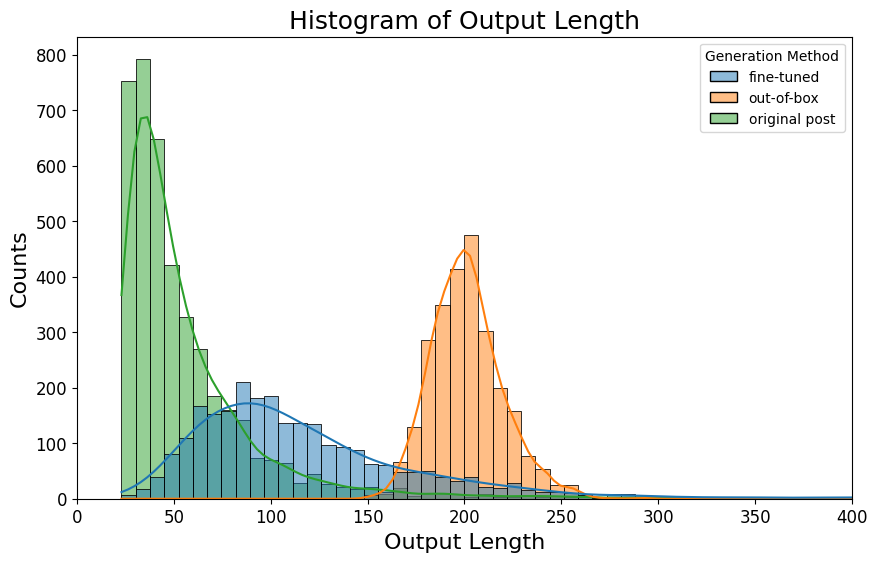

In [ ]:
output['output1_len'] = output['output1'].apply(lambda x: len(word_tokenize(x)))
output['output2_len'] = output['output2'].apply(lambda x: len(word_tokenize(x)))

draw_data_a = output.drop_duplicates(subset = ['question_id'])[['output1_len','output2_len']].rename(columns = {'output1_len':'fine-tuned','output2_len':'out-of-box'}).melt(var_name="Generation Method", value_name="Value")
draw_data_b = output[['output_len']].rename(columns = {'output_len':'original post'}).melt(var_name="Generation Method", value_name="Value")
draw_data = pd.concat([draw_data_a,draw_data_b])

# Plot the histogram using seaborn
plt.figure(figsize=(10, 6))
sns.histplot(draw_data, x="Value", hue="Generation Method", alpha=0.5, kde = True, legend = True, bins = 90)

# Labels and title
plt.xlim(0, 400)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Output Length',size = 16)
plt.ylabel('Counts',size = 16)
plt.title('Histogram of Output Length',size = 18)
plt.savefig('result/output_len_hist.png',dpi = 400)

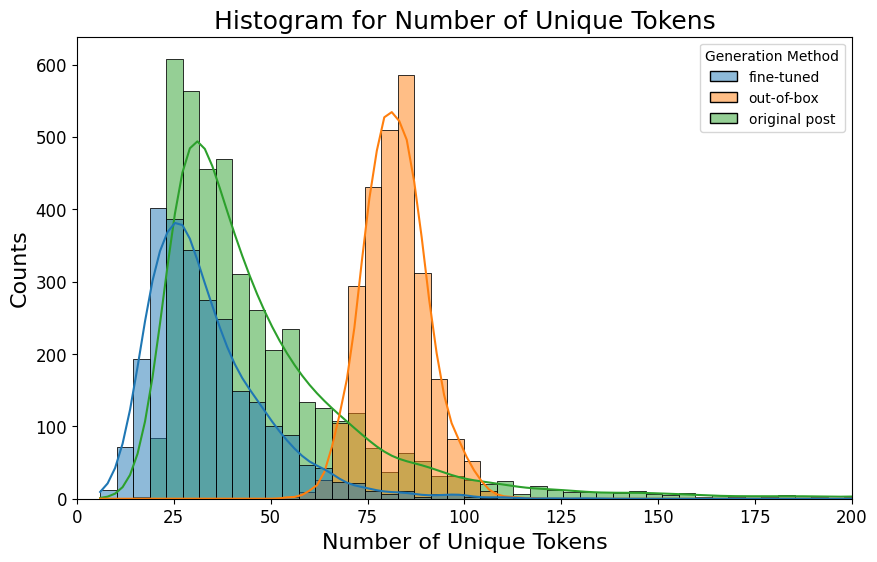

In [ ]:
output['output1_tokens'] = output['output1'].apply(lambda x: n_tokens(x))
output['output2_tokens'] = output['output2'].apply(lambda x: n_tokens(x))
output['output_tokens'] = output['output'].apply(lambda x: n_tokens(x))

draw_data_a = output.drop_duplicates(subset = ['question_id'])[['output1_tokens','output2_tokens']].rename(columns = {'output1_tokens':'fine-tuned','output2_tokens':'out-of-box'}).melt(var_name="Generation Method", value_name="Value")
draw_data_b = output[['output_tokens']].rename(columns = {'output_tokens':'original post'}).melt(var_name="Generation Method", value_name="Value")
draw_data = pd.concat([draw_data_a,draw_data_b])

# Plot the histogram using seaborn
plt.figure(figsize=(10, 6))
sns.histplot(draw_data, x="Value", hue="Generation Method", alpha=0.5, kde = True, legend = True, bins = 90)

# Labels and title
plt.xlim(0, 200)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Number of Unique Tokens',size = 16)
plt.ylabel('Counts',size = 16)
plt.title('Histogram for Number of Unique Tokens',size = 18)
plt.savefig('result/output_ntokens_hist.png',dpi = 400)

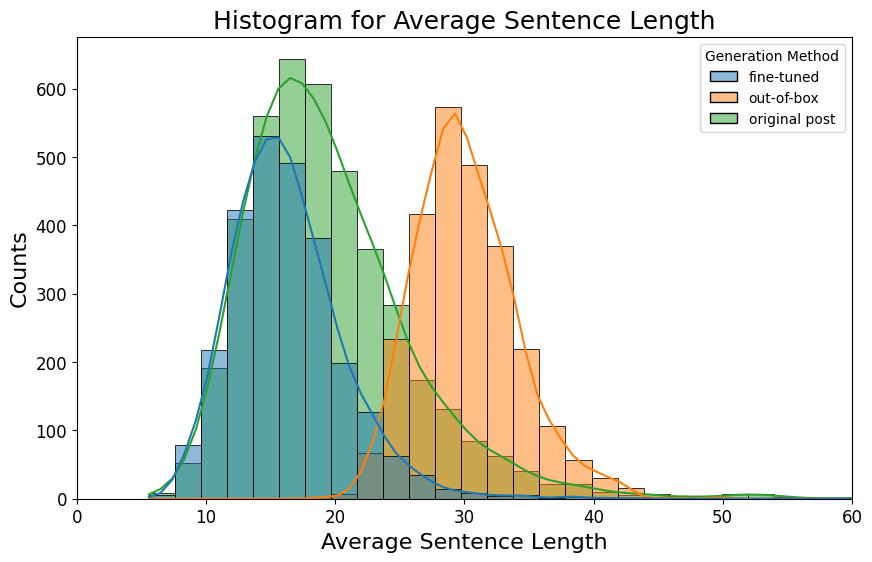

In [ ]:
output['output1_sent'] = output['output1'].apply(lambda x: sentence_len(x))
output['output2_sent'] = output['output2'].apply(lambda x: sentence_len(x))
output['output_sent'] = output['output'].apply(lambda x: sentence_len(x))

draw_data_a = output.drop_duplicates(subset = ['question_id'])[['output1_sent','output2_sent']].rename(columns = {'output1_sent':'fine-tuned','output2_sent':'out-of-box'}).melt(var_name="Generation Method", value_name="Value")
draw_data_b = output[['output_sent']].rename(columns = {'output_sent':'original post'}).melt(var_name="Generation Method", value_name="Value")
draw_data = pd.concat([draw_data_a,draw_data_b])

plt.figure(figsize=(10, 6))
sns.histplot(draw_data, x="Value", hue="Generation Method", alpha=0.5, kde = True, legend = True, bins = 90)

plt.xlim(0, 60)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Average Sentence Length',size = 16)
plt.ylabel('Counts',size = 16)
plt.title('Histogram for Average Sentence Length',size = 18)
plt.savefig('result/output_sent_length_hist.png',dpi = 400)

In [ ]:
output['output1_rouge'] = output.apply(lambda x: compute_rouge(x['output'],x['output1']),axis = 1)
output['output2_rouge'] = output.apply(lambda x: compute_rouge(x['output'],x['output2']),axis = 1)

output['output1_rouge1'] = output['output1_rouge'].apply(lambda x: x['rouge1'].fmeasure)
output['output2_rouge1'] = output['output2_rouge'].apply(lambda x: x['rouge1'].fmeasure)

output['output1_rouge2'] = output['output1_rouge'].apply(lambda x: x['rouge2'].fmeasure)
output['output2_rouge2'] = output['output2_rouge'].apply(lambda x: x['rouge2'].fmeasure)

output['output1_rougel'] = output['output1_rouge'].apply(lambda x: x['rougeL'].fmeasure)
output['output2_rougel'] = output['output2_rouge'].apply(lambda x: x['rougeL'].fmeasure)

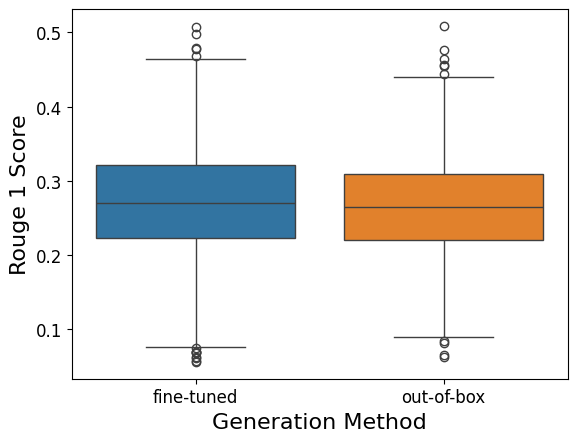

In [ ]:
draw_data = output[['output1_rouge1','output2_rouge1']].rename(columns = {'output1_rouge1':'fine-tuned','output2_rouge1':'out-of-box'}).melt(var_name="Generation Method", value_name="Rouge 1 Score")

sns.boxplot(draw_data, x="Generation Method", y="Rouge 1 Score", hue = 'Generation Method')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Generation Method',size = 16)
plt.ylabel('Rouge 1 Score',size = 16)
plt.savefig('rouge1_score_output.png',dpi = 400)

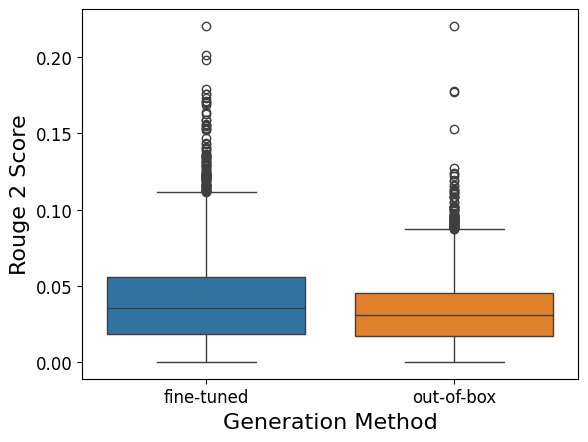

In [ ]:
draw_data = output[['output1_rouge2','output2_rouge2']].rename(columns = {'output1_rouge2':'fine-tuned','output2_rouge2':'out-of-box'}).melt(var_name="Generation Method", value_name="Rouge 2 Score")

sns.boxplot(draw_data, x="Generation Method", y="Rouge 2 Score", hue = 'Generation Method')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Generation Method',size = 16)
plt.ylabel('Rouge 2 Score',size = 16)
plt.savefig('rouge2_score_output.png',dpi = 400)

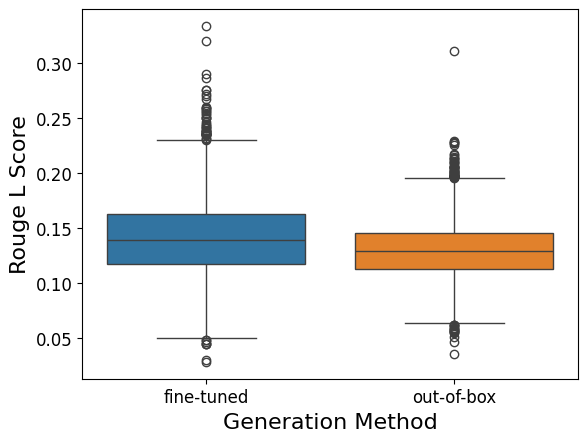

In [ ]:
draw_data = output[['output1_rougel','output2_rougel']].rename(columns = {'output1_rougel':'fine-tuned','output2_rougel':'out-of-box'}).melt(var_name="Generation Method", value_name="Rouge L Score")

sns.boxplot(draw_data, x="Generation Method", y="Rouge L Score", hue = 'Generation Method')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Generation Method',size = 16)
plt.ylabel('Rouge L Score',size = 16)
plt.savefig('rougel_score_output.png',dpi = 400)

In [ ]:
output['input'] = output['title'] + '\n' + output['question']
unique_output = output.drop_duplicates(subset = ['question_id'])[['question_id','output1','output2','prompt2','input']].reset_index(drop = True)

In [ ]:
output['input'] = output['title'] + '\n' + output['question']
unique_output = output.drop_duplicates(subset = ['question_id'])[['output1','output2','prompt2','input']].reset_index(drop = True)

unique_output['output1_emb'] = batch_process_column(unique_output['output1'])
unique_output['output2_emb'] = batch_process_column(unique_output['output2'])
unique_output['prompt2_emb'] = batch_process_column(unique_output['prompt2'])
unique_output['input_emb'] = batch_process_column(unique_output['input'])
unique_output['question_id'] = output.drop_duplicates(subset = ['question_id'])['question_id']

output = pd.merge(output,unique_output,on = 'question_id')
output['output_emb'] = batch_process_column(output['output'])
output.to_parquet('data/output_emb.parquet', index = False)

Embedding input: 100%|██████████| 21/21 [00:23<00:00,  1.10s/it]


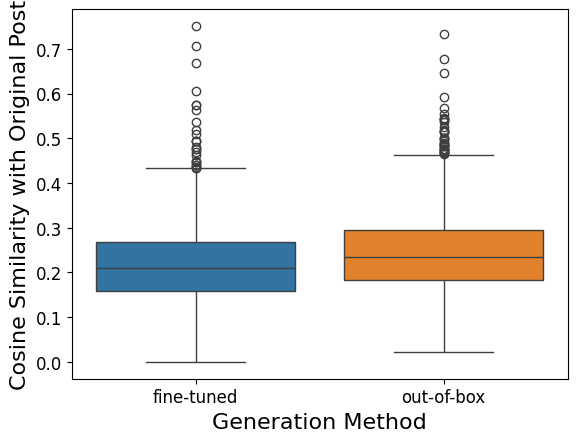

In [ ]:
output['output1_output'] = output.apply(lambda x: cosine_similarity([x['output_emb']], [x['output1_emb']])[0][0], axis = 1)
output['output2_output'] = output.apply(lambda x: cosine_similarity([x['output_emb']], [x['output2_emb']])[0][0], axis = 1)
draw_data = output[['output1_output','output2_output']].rename(columns = {'output1_output':'fine-tuned','output2_output':'out-of-box'}).melt(var_name="Generation Method", value_name="Cosine Similarity")

sns.boxplot(draw_data, x="Generation Method", y="Cosine Similarity", hue = 'Generation Method')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Generation Method',size = 16)
plt.ylabel('Cosine Similarity with Original Post',size = 16)
plt.savefig('cosine_similarity_original_post.png',dpi = 400)

In [ ]:
output['output1_prompt'] = output.apply(lambda x: cosine_similarity([x['output1_emb']], [x['prompt2_emb']])[0][0], axis = 1)
output['output2_prompt'] = output.apply(lambda x: cosine_similarity([x['output2_emb']], [x['prompt2_emb']])[0][0], axis = 1)
output['output_prompt'] = output.apply(lambda x: cosine_similarity([x['output_emb']], [x['prompt2_emb']])[0][0], axis = 1)

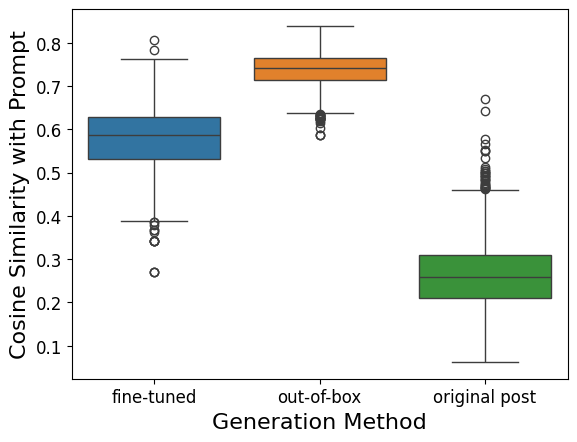

In [ ]:
draw_data = output[['output1_prompt','output2_prompt','output_prompt']].rename(columns = {'output1_prompt':'fine-tuned','output2_prompt':'out-of-box','output_prompt':'original post'}).melt(var_name="Generation Method", value_name="Cosine Similarity")

sns.boxplot(draw_data, x="Generation Method", y="Cosine Similarity", hue = 'Generation Method')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Generation Method',size = 16)
plt.ylabel('Cosine Similarity with Prompt',size = 16)
plt.savefig('cosine_similarity_prompt.png',dpi = 400)

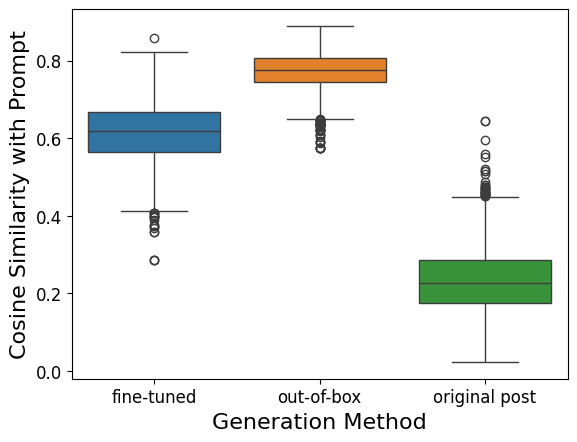

In [ ]:
output['output1_input'] = output.apply(lambda x: cosine_similarity([x['output1_emb']], [x['input_emb']])[0][0], axis = 1)
output['output2_input'] = output.apply(lambda x: cosine_similarity([x['output2_emb']], [x['input_emb']])[0][0], axis = 1)
output['output_input'] = output.apply(lambda x: cosine_similarity([x['output_emb']], [x['input_emb']])[0][0], axis = 1)

draw_data = output[['output1_input','output2_input','output_input']].rename(columns = {'output1_input':'fine-tuned','output2_input':'out-of-box','output_input':'original post'}).melt(var_name="Generation Method", value_name="Cosine Similarity")

sns.boxplot(draw_data, x="Generation Method", y="Cosine Similarity", hue = 'Generation Method')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Generation Method',size = 16)
plt.ylabel('Cosine Similarity with Prompt',size = 16)
plt.savefig('cosine_similarity_input.png',dpi = 400)

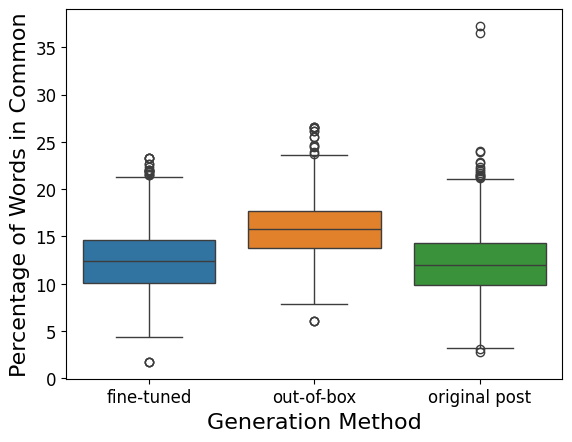

In [ ]:
output['output1_prompt_words'] = output.apply(lambda x: common_words_percentage(x['output1_x'], x['prompt2_x']), axis = 1)
output['output2_prompt_words'] = output.apply(lambda x: common_words_percentage(x['output2_x'], x['prompt2_x']), axis = 1)
output['output_prompt_words'] = output.apply(lambda x: common_words_percentage(x['output'], x['prompt2_x']), axis = 1)

draw_data = output[['output1_prompt_words','output2_prompt_words','output_prompt_words']].rename(columns = {'output1_prompt_words':'fine-tuned','output2_prompt_words':'out-of-box','output_prompt_words':'original post'}).melt(var_name="Generation Method", value_name="Percentage")

sns.boxplot(draw_data, x="Generation Method", y="Percentage", hue = 'Generation Method')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Generation Method',size = 16)
plt.ylabel('Percentage of Words in Common',size = 16)
plt.savefig('percentage_words_in_common.png',dpi = 400)

In [ ]:
for idx, row in tqdm(unique_output.iterrows(), total = len(unique_output)):
  score = evaluate_advice(prompt_template_relavence,
                                     row['input'],
                                     row['output1'])
  unique_output.loc[idx,'output1_relavence'] = score
  print(score)

for idx, row in tqdm(unique_output.iterrows(), total = len(unique_output)):
  score = evaluate_advice(prompt_template_accuracy,
                                     row['input'],
                                     row['output1'])
  unique_output.loc[idx,'output1_accuracy'] = score
  print(score)

for idx, row in tqdm(unique_output.iterrows(), total = len(unique_output)):
  score = evaluate_advice(prompt_template_confidence,
                                     row['input'],
                                     row['output1'])
  unique_output.loc[idx,'output1_confidence'] = score
  print(score)

for idx, row in tqdm(unique_output.iterrows(), total = len(unique_output)):
  score = evaluate_advice(prompt_template_clarity,
                                     row['input'],
                                     row['output1'])
  unique_output.loc[idx,'output1_clarity'] = score
  print(score)

for idx, row in tqdm(unique_output.iterrows(), total = len(unique_output)):
  score = evaluate_advice(prompt_template_usefulness,
                                     row['input'],
                                     row['output1'])
  unique_output.loc[idx,'output1_usefulness'] = score
  print(score)

for idx, row in tqdm(unique_output.iterrows(), total = len(unique_output)):
  score = evaluate_advice(prompt_template_relavence,
                                     row['input'],
                                     row['output2'])
  unique_output.loc[idx,'output2_relavence'] = score
  print(score)

for idx, row in tqdm(unique_output.iterrows(), total = len(unique_output)):
  score = evaluate_advice(prompt_template_accuracy,
                                     row['input'],
                                     row['output2'])
  unique_output.loc[idx,'output2_accuracy'] = score
  print(score)

for idx, row in tqdm(unique_output.iterrows(), total = len(unique_output)):
  score = evaluate_advice(prompt_template_confidence,
                                     row['input'],
                                     row['output2'])
  unique_output.loc[idx,'output2_confidence'] = score
  print(score)

for idx, row in tqdm(unique_output.iterrows(), total = len(unique_output)):
  score = evaluate_advice(prompt_template_clarity,
                                     row['input'],
                                     row['output2'])
  unique_output.loc[idx,'output2_clarity'] = score
  print(score)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
for idx, row in tqdm(output.iterrows(), total = len(unique_output)):
  score = evaluate_advice(prompt_template_relavence,
                                     row['input'],
                                     row['output'])
  output.loc[idx,'output_relavence'] = score
  print(score)

for idx, row in tqdm(output.iterrows(), total = len(unique_output)):
  score = evaluate_advice(prompt_template_accuracy,
                                     row['input'],
                                     row['output'])
  output.loc[idx,'output_accuracy'] = score
  print(score)

for idx, row in tqdm(output.iterrows(), total = len(unique_output)):
  score = evaluate_advice(prompt_template_confidence,
                                     row['input'],
                                     row['output'])
  output.loc[idx,'output_confidence'] = score
  print(score)

for idx, row in tqdm(output.iterrows(), total = len(unique_output)):
  score = evaluate_advice(prompt_template_clarity,
                                     row['input'],
                                     row['output'])
  output.loc[idx,'output_clarity'] = score
  print(score)

for idx, row in tqdm(output.iterrows(), total = len(unique_output)):
  score = evaluate_advice(prompt_template_usefulness,
                                     row['input'],
                                     row['output'])
  output.loc[idx,'output_usefulness'] = score
  print(score)

output.to_csv('data/score2',index = False)


In [ ]:
unique_output.to_csv('data/score1',index = False)
output.to_csv('data/score2',index = False)

In [ ]:
score1 = pd.read_csv('data/score1')
score2 = pd.read_csv('data/score2')
score1['question_id'] = unique_output['question_id']
score1 = score1[['output1_relavence',
       'output1_accuracy', 'output1_confidence', 'output1_clarity',
       'output1_usefulness', 'output2_relavence', 'output2_accuracy',
       'output2_confidence', 'output2_clarity', 'output2_usefulness',
       'question_id']]
full_score = pd.merge(score1,score2,on = 'question_id').dropna().reset_index(drop = True)

In [ ]:
full_score.columns

Index(['output1_relavence', 'output1_accuracy', 'output1_confidence',
       'output1_clarity', 'output1_usefulness', 'output2_relavence',
       'output2_accuracy', 'output2_confidence', 'output2_clarity',
       'output2_usefulness', 'question_id', 'output1', 'output2', 'title',
       'question', 'output', 'score', 'output_len', 'prompt1', 'prompt2',
       'input', 'output_relavence', 'output_accuracy', 'output_confidence',
       'output_clarity', 'output_usefulness'],
      dtype='object')

In [ ]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

X = full_score[['output_relavence', 'output_accuracy', 'output_confidence','output_clarity', 'output_usefulness']]
y = full_score['score']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

model = sm.OLS(y_train, X_train).fit()
y_pred = model.predict(X_test)

print(model.summary())
r_squared_test = 1 - np.sum((y_test - y_pred) ** 2) / np.sum((y_test - y_test.mean()) ** 2)
print(f"Test R-squared: {r_squared_test:.4f}")

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.149
Date:                Tue, 04 Mar 2025   Prob (F-statistic):              0.332
Time:                        02:05:06   Log-Likelihood:                -13361.
No. Observations:                2756   AIC:                         2.673e+04
Df Residuals:                    2750   BIC:                         2.677e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 7.3594      2.63

In [ ]:
score1.columns

Index(['output1', 'output2', 'prompt2', 'input', 'output1_relavence',
       'output1_accuracy', 'output1_confidence', 'output1_clarity',
       'output1_usefulness', 'output2_relavence', 'output2_accuracy',
       'output2_confidence', 'output2_clarity', 'output2_usefulness',
       'output_relavence', 'question_id'],
      dtype='object')